# Contextual Bandits Agent with Policy Gradient Method (Deterministic) in Prediction Markets Problem
---
This is a program that simulates an agent who trades in a prediction market. The problem that the prediction market aims to solve is to predict the real distribution of a random variable. We define the random variable as the colour of a bucket. The problem design comes from a human-subjective experiment for decision markets.

In [2]:
import matplotlib.pyplot as plt
import traceback
from tqdm.notebook import tnrange
import pandas as pd

In [3]:
from scipy.special import logit, expit
from PolicyGradientAgent import DeterministicGradientAgent
from Environment import *

In [15]:
learning_rate_theta = 0.001
decay_rate = 0 #0.001
learning_rate_wq = 0.0003
memory_size = 256
batch_size = 256
training_episodes = 6000 * 5
beta1 = 0.9
beta2 = 0.9999
# Algorithm: adam, momentum, regular
algorithm = 'regular'
# Bucket parameters
prior_red = 0.5
pr_red_ball_red_bucket = 2/3
pr_red_ball_blue_bucket = 1/3

agent = DeterministicGradientAgent(feature_shape=[1, 3], learning_rate_theta=learning_rate_theta, learning_rate_wq=learning_rate_wq, memory_size= memory_size, batch_size=batch_size ,beta1=beta1, beta2=beta2)

explorer = Explorer(feature_shape=[1, 3], learning= False, init_learning_rate=0.003)

qv_history = []

reward_history_list = []
regret_history_list = []
average_reward = 0
actual_average_reward = 0

mean_weights_history_list = []

r_ball_mean_history_list = []
b_ball_mean_history_list = []


r_ball_pred_history_list = []
b_ball_pred_history_list = []

grad_r_ball_mean_history_list = []
grad_b_ball_mean_history_list = []


grad_r_ball_v_mean_history_list = []
grad_b_ball_v_mean_history_list = []


grad_r_ball_adam_mean_history_list = []
grad_b_ball_adam_mean_history_list = []

explorer_std_list = []

grad_mean_history_list = []
mean_history_list = []
actual_report_history_list = []


for t in tnrange(training_episodes):
    # Prepare a bucket and a prediction market
    bucket = Bucket(prior_red, pr_red_ball_red_bucket, pr_red_ball_blue_bucket)
    pm = PredictionMarket(outcomes_list=['red_bucket', 'blue_bucket'])
    signal = bucket.signal()
    x = one_hot_encode(signal)
    x.append(prior_red)

    mean = agent.report(x)
    pi = expit(mean)
    actual_report = [pi, 1-pi]
    explorer.set_parameters(mean=mean)
    noised_report = explorer.report(x)
    
    explorer_std_list.append(explorer.std)

    pm.report(noised_report)
    R = pm.log_resolve(bucket_colour_to_num[bucket.colour])
    
    pm.report(actual_report)
    actual_R = pm.log_resolve(bucket_colour_to_num[bucket.colour])


    average_reward = average_reward + (1/ (t + 1)) * (R - average_reward)
    actual_average_reward = actual_average_reward + (1/ (t + 1)) * (actual_R - actual_average_reward)
    reward_history_list.append([R, average_reward, actual_R, actual_average_reward])
    mean_weights_history_list.append(agent.theta_mean[0].tolist())   

    R_perf = 0
    red_score = np.log(actual_report[0]) - np.log(0.5)
    blue_score = np.log(actual_report[1]) - np.log(0.5)
    red_expectation = pr_red_ball_red_bucket  * red_score + (1 - pr_red_ball_red_bucket)  * blue_score
    blue_expectation = pr_red_ball_blue_bucket  * red_score + (1 - pr_red_ball_blue_bucket)  * blue_score
    red_max_expectation = pr_red_ball_red_bucket * (np.log(pr_red_ball_red_bucket) - np.log(0.5)) + (1 - pr_red_ball_red_bucket) * (np.log(1 - pr_red_ball_red_bucket) - np.log(0.5))
    blue_max_expectation = pr_red_ball_blue_bucket * (np.log(pr_red_ball_blue_bucket) - np.log(0.5)) + (1 - pr_red_ball_blue_bucket) * (np.log(1 - pr_red_ball_blue_bucket) - np.log(0.5))
    if signal == 'red':
        R_perf = red_expectation
        regret = red_max_expectation - red_expectation
    else:
        R_perf = blue_expectation
        regret = blue_max_expectation - blue_expectation
    regret_history_list.append([regret, signal])
    
    
    action = logit(noised_report[0])
    agent.store_experience(x, action, R, t)

    explorer.update(R, x)

    try:
        grad_mean, v_dw_mean_corrected, s_dw_mean_corrected, q, v = agent.batch_update(t, algorithm= algorithm)
    except AssertionError:
        tb = traceback.format_exc()
        print(tb)

    agent.learning_rate_decay(epoch=t, decay_rate=decay_rate)
    if explorer.learning:
        explorer.learning_rate_decay(epoch=t, decay_rate=decay_rate)
    qv_history.append([v, q])
        
    if signal == 'red':
        r_ball_pred_history_list.append(noised_report[0])
        r_ball_mean_history_list.append(mean)      
    else:
        b_ball_pred_history_list.append(noised_report[0])
        b_ball_mean_history_list.append(mean)
        
    actual_report_history_list.append([actual_report[0], signal])
    mean_history_list.append([mean, signal])
    grad_mean_history_list.append(grad_mean[0, :])    

        
    grad_r_ball_mean_history_list.append(grad_mean[0, 0])
    ##########
    grad_r_ball_v_mean_history_list.append(v_dw_mean_corrected[0, 0])
    grad_r_ball_adam_mean_history_list.append(s_dw_mean_corrected[0, 0])
    
    grad_b_ball_mean_history_list.append(grad_mean[0, 1])
    #########
    grad_b_ball_v_mean_history_list.append(v_dw_mean_corrected[0, 1])
    grad_b_ball_adam_mean_history_list.append(s_dw_mean_corrected[0, 1])        

  0%|          | 0/30000 [00:00<?, ?it/s]

Updating weights with regular algorithm.


In [16]:
qv_array = np.array(qv_history)

reward_history_df = pd.DataFrame(reward_history_list, columns=['noised_reward', 'noised_average_reward', 'actual_reward', 'actual_average_reward'])
regret_history_df = pd.DataFrame(regret_history_list, columns=['regret', 'signal'])

mean_weights_history = np.array(mean_weights_history_list)


grad_r_ball_mean_history = np.array(grad_r_ball_mean_history_list)
grad_b_ball_mean_history = np.array(grad_b_ball_mean_history_list)


grad_r_ball_v_mean_history = np.array(grad_r_ball_v_mean_history_list)
grad_b_ball_v_mean_history = np.array(grad_b_ball_v_mean_history_list)


grad_r_ball_adam_mean_history = np.array(grad_r_ball_adam_mean_history_list)
grad_b_ball_adam_mean_history = np.array(grad_b_ball_adam_mean_history_list)

grad_mean_history_df = pd.DataFrame(grad_mean_history_list, columns=['red_ball', 'blue_ball', 'prior'])
actual_report_history_df = pd.DataFrame(actual_report_history_list, columns=['report', 'signal'])
mean_history_df = pd.DataFrame(mean_history_list, columns=['mean', 'signal'])

In [17]:
agent.theta_mean

array([[ 0.8949689 , -0.8681632 ,  0.01340285]])

Towards best ratio:  0.6949638728086422


Text(0.5, 0.98, 'Actual Rewards and Average')

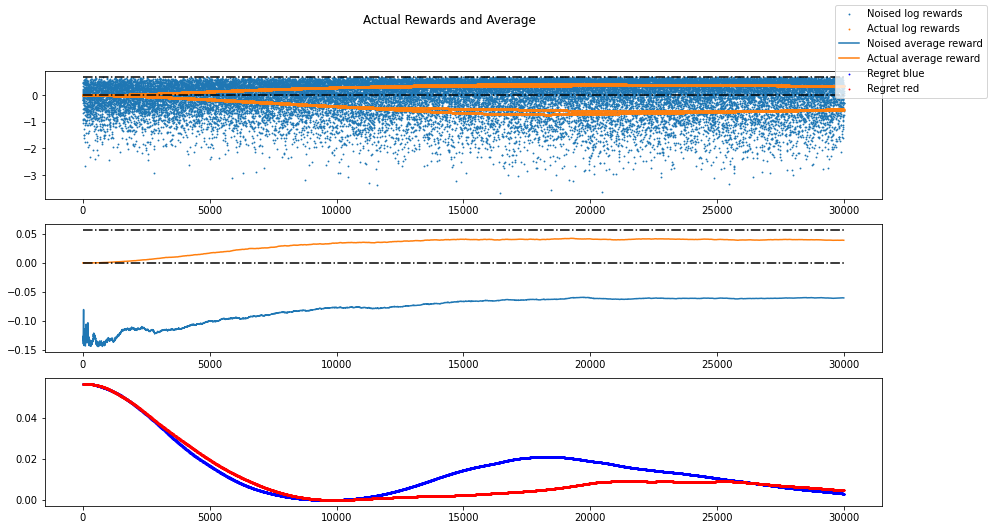

In [20]:
theoretical_best = 2/3*(np.log(2/3)-np.log(1/2)) + 1/3*(np.log(1/3)-np.log(1/2))
empirical_best = reward_history_df.iloc[-100:, 3].mean()
print('Towards best ratio: ', empirical_best/ theoretical_best)
fig, axs = plt.subplots(3, figsize=(15, 8))
axs[0].scatter(x=reward_history_df.index, y=reward_history_df['noised_reward'],label = 'Noised log rewards', marker='.', s=3, zorder=-100)
axs[0].scatter(x=reward_history_df.index, y=reward_history_df['actual_reward'],label = 'Actual log rewards', marker='.', s=3, zorder=-99)
axs[1].plot(not_outlier(reward_history_df.iloc[:, 1]),zorder= -100, label = 'Noised average reward')
axs[1].plot(not_outlier(reward_history_df.iloc[:, 3]),zorder= -99, label = 'Actual average reward')
for signal, df in regret_history_df.reset_index().groupby('signal'):
    axs[2].scatter(x=df['index'], y=df['regret'], label='Regret ' + signal, marker='.', c=signal, s=3)
axs[0].hlines(y=np.log(2), xmin=0, xmax=reward_history_df.shape[0], colors='black', linestyles='dashdot')
axs[0].hlines(y=0.0, xmin=0, xmax=reward_history_df.shape[0] , colors='black', linestyles='dashdot')
axs[1].hlines(y=0.0, xmin=0, xmax=reward_history_df.shape[0] , colors='black', linestyles='dashdot')
axs[1].hlines(y=theoretical_best, xmin=0, xmax=reward_history_df.shape[0] , colors='black', linestyles='dashdot')
fig.legend()
fig.suptitle('Actual Rewards and Average')

Text(0.5, 1.0, 'Approximated value and Actual value')

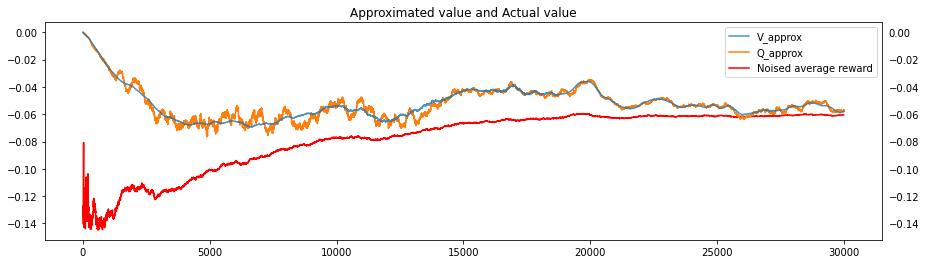

In [24]:
fig = plt.figure(figsize=(15, 4))
plt.plot(qv_array[:, 0], zorder = -99, label = 'V_approx', alpha=0.8)
plt.plot(qv_array[:, 1], zorder= -100, label = 'Q_approx')
[ax] = fig.axes
ax.tick_params(labelright=True)
plt.plot(not_outlier(reward_history_df.iloc[:, 1]), 'r', zorder= -101, label = 'Noised average reward' )
plt.legend()
plt.title('Approximated value and Actual value')

Text(0.5, 1.0, 'Actual Report')

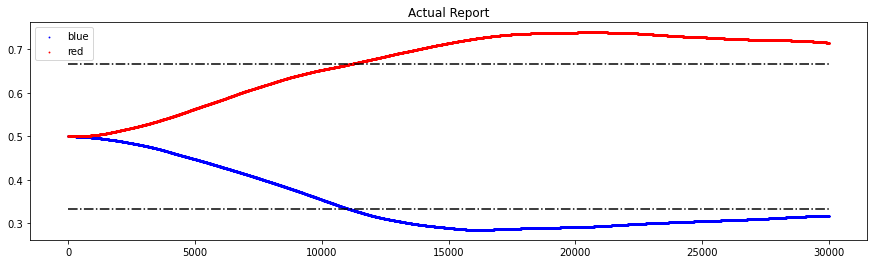

In [75]:
fig, ax = plt.subplots(figsize=(15, 4))
for signal, df in actual_report_history_df.reset_index().groupby('signal'):
    ax.scatter(x=df['index'], y=df['report'], label=signal, marker='.', c=signal, s=3)
ax.hlines(y=2/3, xmin=0, xmax=len(actual_report_history_df), colors='black', linestyles='dashdot')
ax.hlines(y=1/3, xmin=0, xmax=len(actual_report_history_df) , colors='black', linestyles='dashdot')
ax.legend()
plt.title('Actual Report')

15086


Text(0.5, 1.0, 'Report')

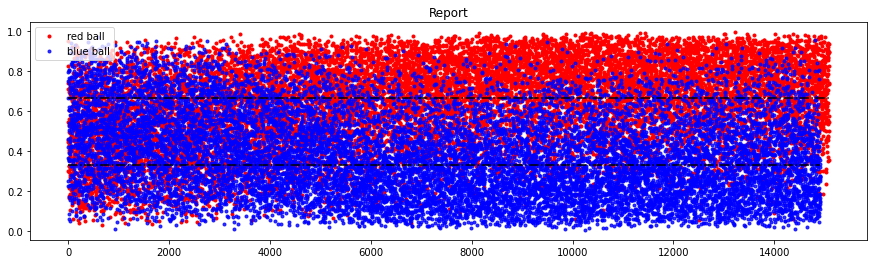

In [76]:
print(len(r_ball_pred_history_list))
fig = plt.figure(figsize=(15, 4))
plt.plot(r_ball_pred_history_list, 'r.', zorder=-100, label='red ball')
plt.plot(b_ball_pred_history_list, 'b.', zorder=-99, label = 'blue ball', alpha=0.8)
plt.hlines(y=2/3, xmin=0, xmax=len(r_ball_pred_history_list), colors='black', linestyles='dashdot')
plt.hlines(y=1/3, xmin=0, xmax=len(b_ball_pred_history_list) , colors='black', linestyles='dashdot')
plt.legend()
plt.title('Report')

In [77]:
print(expit(agent.report([1, 0, 0.5])))

0.7153942637662724


In [78]:
print(expit(agent.report([0, 1, 0.5])))

0.31588600610012785


In [79]:
grad_mean_successive_dot = np.sum(grad_mean_history_df.iloc[:, [1]].values * np.roll(grad_mean_history_df.iloc[:, [1]].values, 1, axis=0), axis=1)[1:]
grad_mean_successive_dot

array([0.00000000e+00, 1.76881947e-09, 1.47057301e-08, ...,
       1.19840215e-05, 1.19783247e-05, 1.19730209e-05])

In [80]:
(mark_index, ) = np.where(grad_mean_successive_dot < 0)
mark_index

array([16415])

In [81]:
def phase_change_coordinates(mark_index, df):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    coord_list = []
    prev_x = 0
    for x in mark_index:
        if x > 50:
            if x > prev_x + 2000:
                coord_list.append((x, df.select_dtypes(include=numerics).loc[x, :].max()))
                prev_x = x
    return coord_list

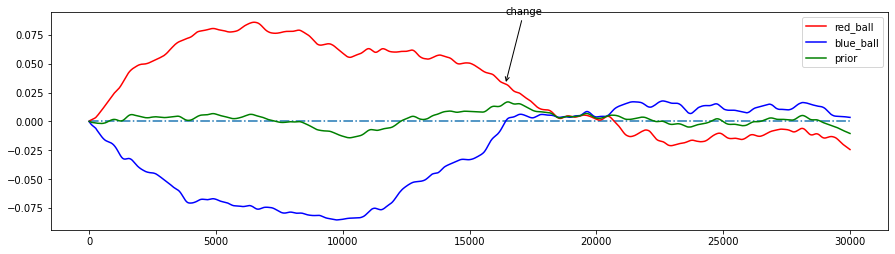

In [82]:
fig, ax = plt.subplots(figsize=(15, 4))
grad_mean_history_df.plot(ax=ax, color=['red', 'blue', 'green'])
ax.hlines(y=0, xmin=0, xmax=len(grad_mean_history_df), linestyles='dashdot')
for coord in phase_change_coordinates(mark_index, grad_mean_history_df):
    plt.annotate('change', xy=coord, xytext=(coord[0], coord[1] + 0.06), arrowprops=dict(arrowstyle="->"))

In [83]:
from scipy.ndimage import uniform_filter1d

Text(0.5, 1.0, 'Successive gradients dot product size 1000 moving average')

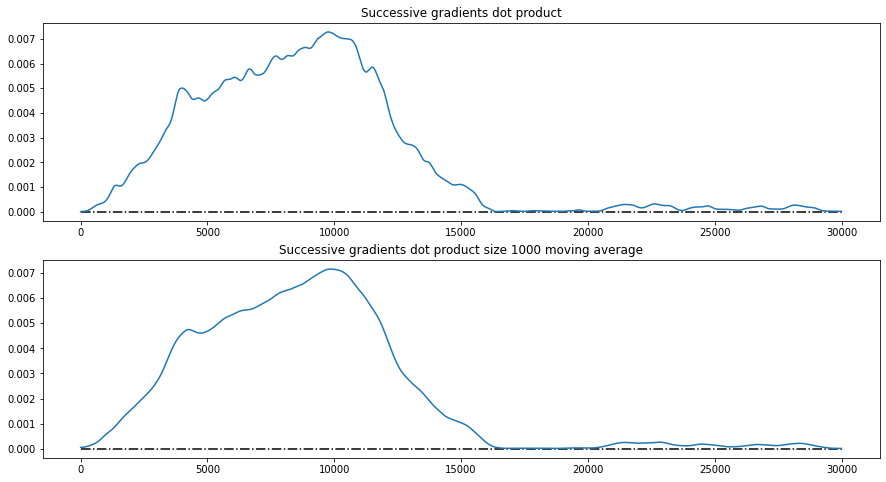

In [84]:
moving_size = 1000
fig, axs = plt.subplots(2, figsize=(15, 8))
axs[0].plot(grad_mean_successive_dot)
axs[0].hlines(y=0, xmin=0, xmax=len(grad_mean_successive_dot), linestyles='dashdot', color='black')
axs[0].set_title('Successive gradients dot product')
axs[1].plot(uniform_filter1d(grad_mean_successive_dot, size=moving_size))
axs[1].hlines(y=0, xmin=0, xmax=len(grad_mean_successive_dot), linestyles='dashdot', color='black')
axs[1].set_title('Successive gradients dot product size %i moving average'%moving_size)

In [85]:
if explorer.learning:
    fig = plt.figure(figsize=(15, 4))
    plt.plot(explorer_std_list)
    plt.title('Explorer Standard Diviation')

In [86]:
import matplotlib.lines as mlines

Text(0.5, 1.0, 'Mean')

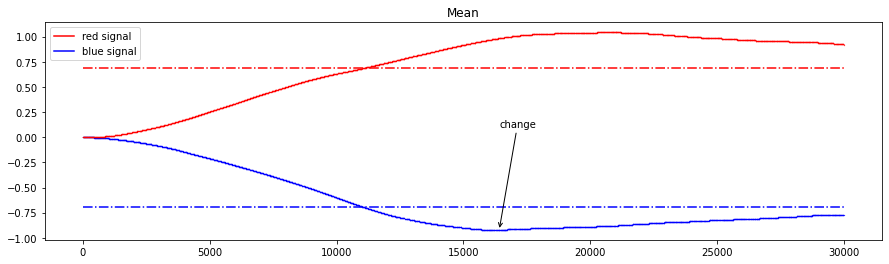

In [87]:
fig, ax = plt.subplots(figsize=(15, 4))
for signal, df in mean_history_df.reset_index().groupby('signal'):
    ax.scatter(x=df['index'], y=df['mean'], label=signal, marker='.', c=signal, alpha=0.6, s=0.1)
plt.hlines(y=np.log(2), xmin=0, xmax=len(mean_history_df), colors='red', linestyles='dashdot')
plt.hlines(y=np.log(1/2), xmin=0, xmax=len(mean_history_df) , colors='blue', linestyles='dashdot')
red_line = mlines.Line2D([], [], color='red', label='red signal')
blue_line = mlines.Line2D([], [], color='blue', label='blue signal')
for coord in phase_change_coordinates(mark_index, mean_history_df):
    plt.annotate('change', xy=coord, xytext=(coord[0], 0.1), arrowprops=dict(arrowstyle="->"))
ax.legend(handles=[red_line, blue_line])
plt.title('Mean')

Text(0.5, 1.0, 'Weights for Mean')

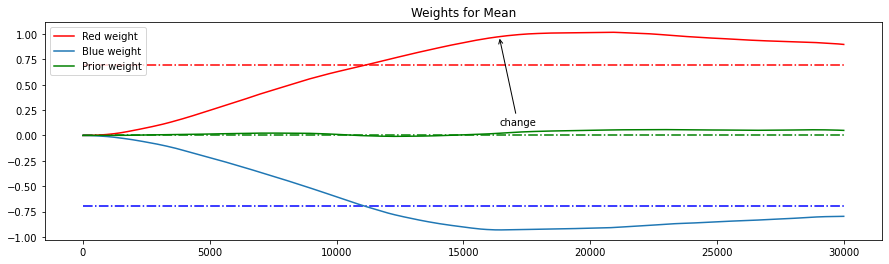

In [88]:
fig = plt.figure(figsize=(15, 4))
plt.plot(mean_weights_history[1:, 0], 'r', label='Red weight')
plt.plot(mean_weights_history[1:, 1], label='Blue weight')
plt.plot(mean_weights_history[1:, 2], 'g', label='Prior weight')
plt.hlines(y=np.log(2), xmin=0, xmax=len(mean_weights_history), colors='red', linestyles='dashdot')
plt.hlines(y=np.log(1/2), xmin=0, xmax=len(mean_weights_history) , colors='blue', linestyles='dashdot')
plt.hlines(y=0, xmin=0, xmax=len(mean_weights_history) , colors='green', linestyles='dashdot')
for coord in phase_change_coordinates(mark_index, pd.DataFrame(mean_weights_history)):
    plt.annotate('change', xy=coord, xytext=(coord[0], 0.1), arrowprops=dict(arrowstyle="->"))
plt.legend()
plt.title('Weights for Mean')

Text(0.5, 0.98, 'Signal Mean Gradients')

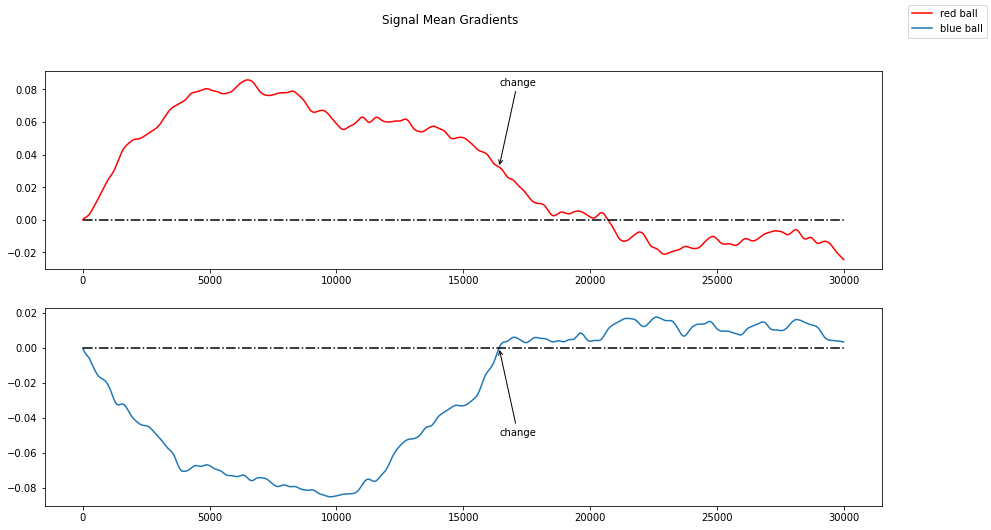

In [89]:
fig, axs = plt.subplots(2, figsize=(15, 8))
axs[0].plot(grad_r_ball_mean_history, 'r', label = 'red ball', zorder=-100)
axs[1].plot(grad_b_ball_mean_history,label = 'blue ball', zorder=-100)
axs[0].hlines(y=0, xmin=0, xmax=grad_r_ball_mean_history.shape[0], colors='black', linestyles='dashdot')
axs[1].hlines(y=0, xmin=0, xmax=grad_b_ball_mean_history.shape[0], colors='black', linestyles='dashdot')
for coord in phase_change_coordinates(mark_index, pd.DataFrame(grad_r_ball_mean_history)):
    axs[0].annotate('change', xy=coord, xytext=(coord[0], coord[1] + 0.05), arrowprops=dict(arrowstyle="->"))
for coord in phase_change_coordinates(mark_index, pd.DataFrame(grad_b_ball_mean_history)):
    axs[1].annotate('change', xy=coord, xytext=(coord[0], coord[1] - 0.05), arrowprops=dict(arrowstyle="->"))  
fig.legend()
fig.suptitle('Signal Mean Gradients')

Text(0.5, 0.98, 'Signal Mean Gradients (momentum)')

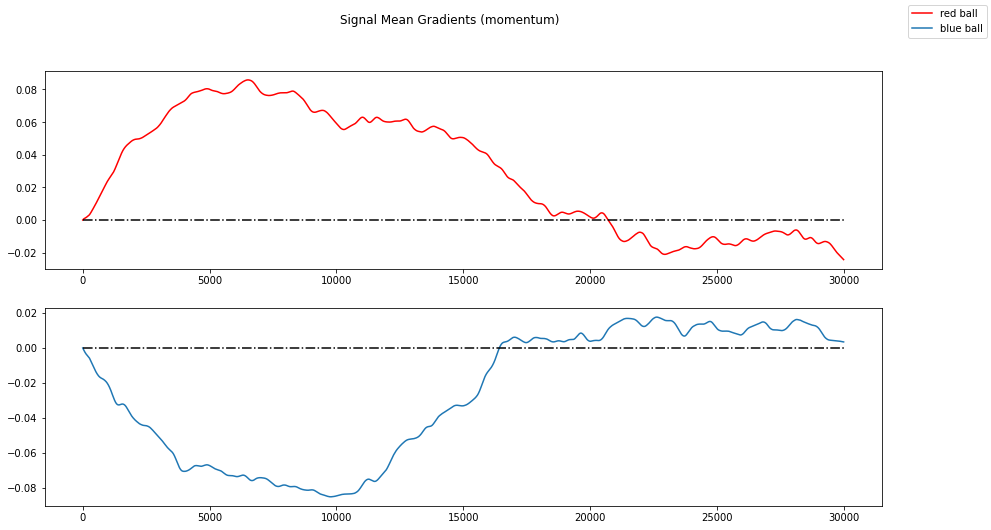

In [90]:
fig, axs = plt.subplots(2, figsize=(15, 8))
axs[0].plot(grad_r_ball_v_mean_history, 'r', label = 'red ball', zorder=-100)
axs[1].plot(grad_b_ball_v_mean_history,label = 'blue ball', zorder=-100)
axs[0].hlines(y=0, xmin=0, xmax=grad_r_ball_v_mean_history.shape[0], colors='black', linestyles='dashdot')
axs[1].hlines(y=0, xmin=0, xmax=grad_b_ball_v_mean_history.shape[0], colors='black', linestyles='dashdot')
fig.legend()
fig.suptitle('Signal Mean Gradients (momentum)')

Text(0.5, 0.98, 'Signal Mean Gradients (Adam)')

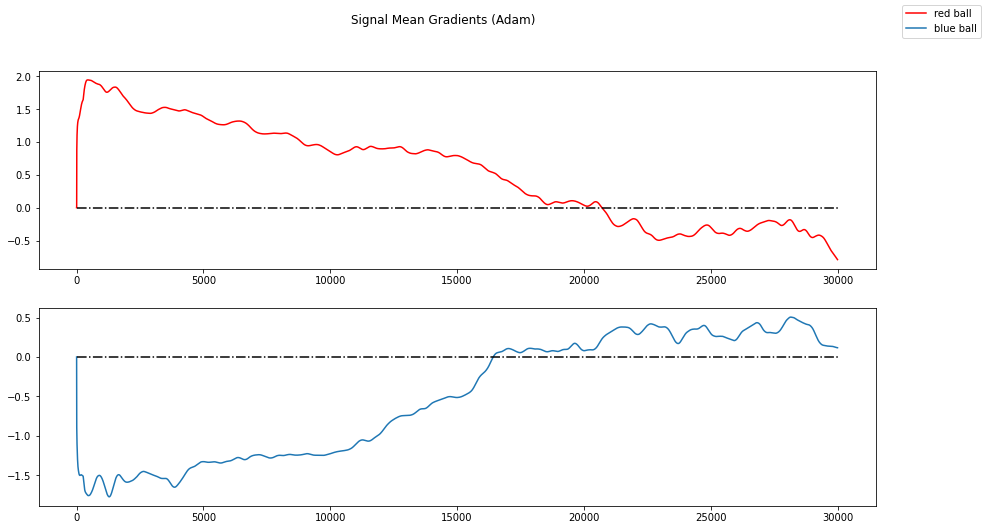

In [91]:
fig, axs = plt.subplots(2, figsize=(15, 8))
axs[0].plot(grad_r_ball_adam_mean_history, 'r', label = 'red ball', zorder=-100)
axs[1].plot(grad_b_ball_adam_mean_history,label = 'blue ball', zorder=-100)
axs[0].hlines(y=0, xmin=0, xmax=grad_r_ball_v_mean_history.shape[0], colors='black', linestyles='dashdot')
axs[1].hlines(y=0, xmin=0, xmax=grad_b_ball_v_mean_history.shape[0], colors='black', linestyles='dashdot')
fig.legend()
fig.suptitle('Signal Mean Gradients (Adam)')

In [92]:
# fig, axs = plt.subplots(2, figsize=(15, 8))
# axs[0].plot(grad_r_ball_mean_history[:, 2], 'r', label = 'red ball', zorder = -100)
# axs[1].plot(grad_b_ball_mean_history[:, 2],label = 'blue ball', zorder = -100)
# axs[0].hlines(y=0, xmin=0, xmax=grad_r_ball_mean_history.shape[0], colors='black', linestyles='dashdot')
# axs[1].hlines(y=0, xmin=0, xmax=grad_b_ball_mean_history.shape[0], colors='black', linestyles='dashdot')
# fig.legend()
# fig.suptitle('Prior Mean Gradient')

In [93]:
# fig, axs = plt.subplots(2, figsize=(15, 8))
# axs[0].plot(grad_r_ball_v_mean_history[:, 2], 'r', label = 'red ball', zorder = -100)
# axs[1].plot(grad_b_ball_v_mean_history[:, 2],label = 'blue ball', zorder = -100)
# axs[0].hlines(y=0, xmin=0, xmax=grad_r_ball_v_mean_history.shape[0], colors='black', linestyles='dashdot')
# axs[1].hlines(y=0, xmin=0, xmax=grad_b_ball_v_mean_history.shape[0], colors='black', linestyles='dashdot')
# fig.legend()
# fig.suptitle('Prior Mean Gradient (Momentum)')